# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from os import listdir
from PIL import Image

# Library untuk preprocessing data
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical

# Library untuk membangun model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50  # Arsitektur ResNet50 
from tensorflow.keras.optimizers import Adam


# Defining Necessary Functions

In [3]:
# Function to convert images to arrays
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, (256, 256))  # ResNet50 expects input size 224x224
            return img_to_array(image)  # Normalize to [0, 1]
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Function to load dataset from a directory (train or test)
def load_dataset(data_dir):
    image_list, label_list = [], []
    for directory in listdir(data_dir):  # Folder names act as labels
        folder_path = os.path.join(data_dir, directory)
        if os.path.isdir(folder_path):  # Check if the path is a directory
            for file in listdir(folder_path):  # Iterate through files in the folder
                image_path = os.path.join(folder_path, file)
                image = convert_image_to_array(image_path)
                if image.size != 0:
                    image_list.append(image)
                    label_list.append(directory)  # Use folder name as label
    return np.array(image_list), np.array(label_list)

# Function to visualize predictions
def output_plot(image, model, class_labels):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Make prediction with the model
    predictions = model.predict(image.reshape(1, 224, 224, 3))

    # Display the input image
    axs[0].imshow(array_to_img(image))
    axs[0].axis('off')
    
    # Display prediction probabilities
    prediction_values = predictions[0]
    max_index = np.argmax(prediction_values)
    colors = ['green' if i == max_index else 'blue' for i in range(len(class_labels))]

    axs[1].barh(class_labels, prediction_values, color=colors)
    axs[1].set_xlim([0, 1])
    axs[1].set_title('Predictions')

    plt.tight_layout()
    plt.show()


# Loading Data

In [4]:

dir_path = r"D:/MATA KULIAH/SEMESTER 5/PM/Week 14/Praktikum/Data baru"
all_labels = [name for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]
binary_labels = [int(i) for i in range(len(all_labels))]
images, labels = load_dataset(dir_path)

In [3]:
!pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


In [4]:
!pip install tensorflow


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ------------------------------- ------ 41.0/48.7 kB 960.0 kB/s eta 0:00:01
     -------------------------------------- 48.7/48.7 kB 818.6 kB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/390.3 MB 4.2 MB/s eta 0:01:34
   ---------------------------------------- 0.3/390.3

In [5]:
!pip install pillow

In [5]:
all_labels

['Antraknosa', 'Cendawan Jelaga', 'Ulat daun']

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.05, random_state=42  # 20% for testing
)

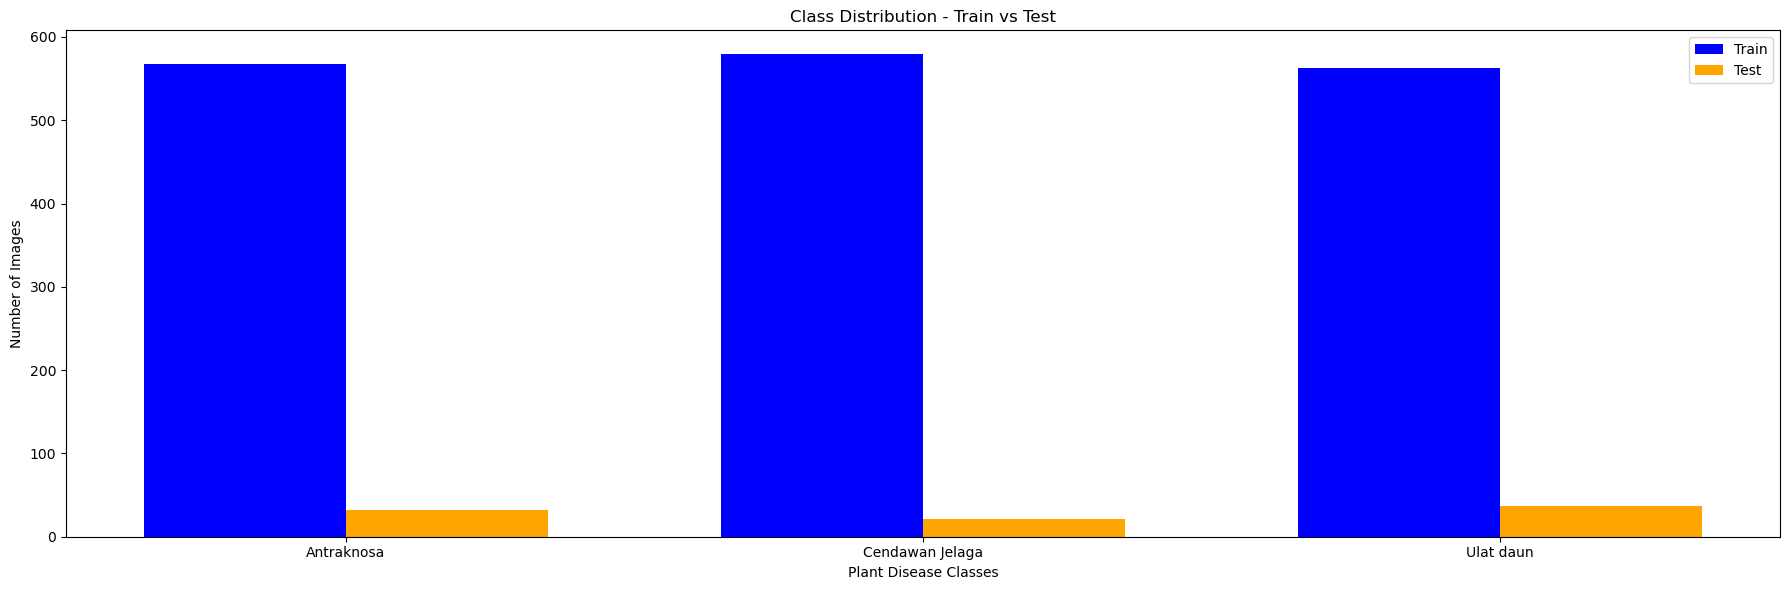

In [7]:
# Memastikan train_labels dan test_labels berupa integer
label_to_index = {label: idx for idx, label in enumerate(all_labels)}  # Mapping label ke angka
train_labels = np.array([label_to_index[label] for label in train_labels])
test_labels = np.array([label_to_index[label] for label in test_labels])

# Menghitung jumlah gambar di setiap kelas untuk train dan test
train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels, minlength=len(all_labels))  # Pastikan minlength sesuai jumlah kelas

# Daftar kelas dan warna
classes = all_labels
train_colors = 'blue'
test_colors = 'orange'

# Membuat plot
bar_width = 0.35
index = np.arange(len(classes))

plt.figure(figsize=(18, 6))
plt.bar(index, train_class_counts, width=bar_width, color=train_colors, label='Train')
plt.bar(index + bar_width, test_class_counts, width=bar_width, color=test_colors, label='Test')

# Memberi label dan judul
plt.xlabel("Plant Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution - Train vs Test")
plt.xticks(index + bar_width / 2, classes)
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()


# Pre Processing Data

In [8]:
# Normalisasi data gambar (konversi nilai piksel ke rentang 0-1 dengan menggunakan float32)
x_train = np.array(train_images, dtype=np.float32) / 255.0
x_test = np.array(test_images, dtype=np.float32) / 255.0

# Konversi label ke format one-hot encoding
y_train = to_categorical(np.array(train_labels), num_classes=len(classes))
y_test = to_categorical(np.array(test_labels), num_classes=len(classes))

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


x_train shape: (1710, 256, 256, 3)
x_test shape: (90, 256, 256, 3)
y_train shape: (1710, 3)
y_test shape: (90, 3)


# Visualization

# a. Sample Train Images

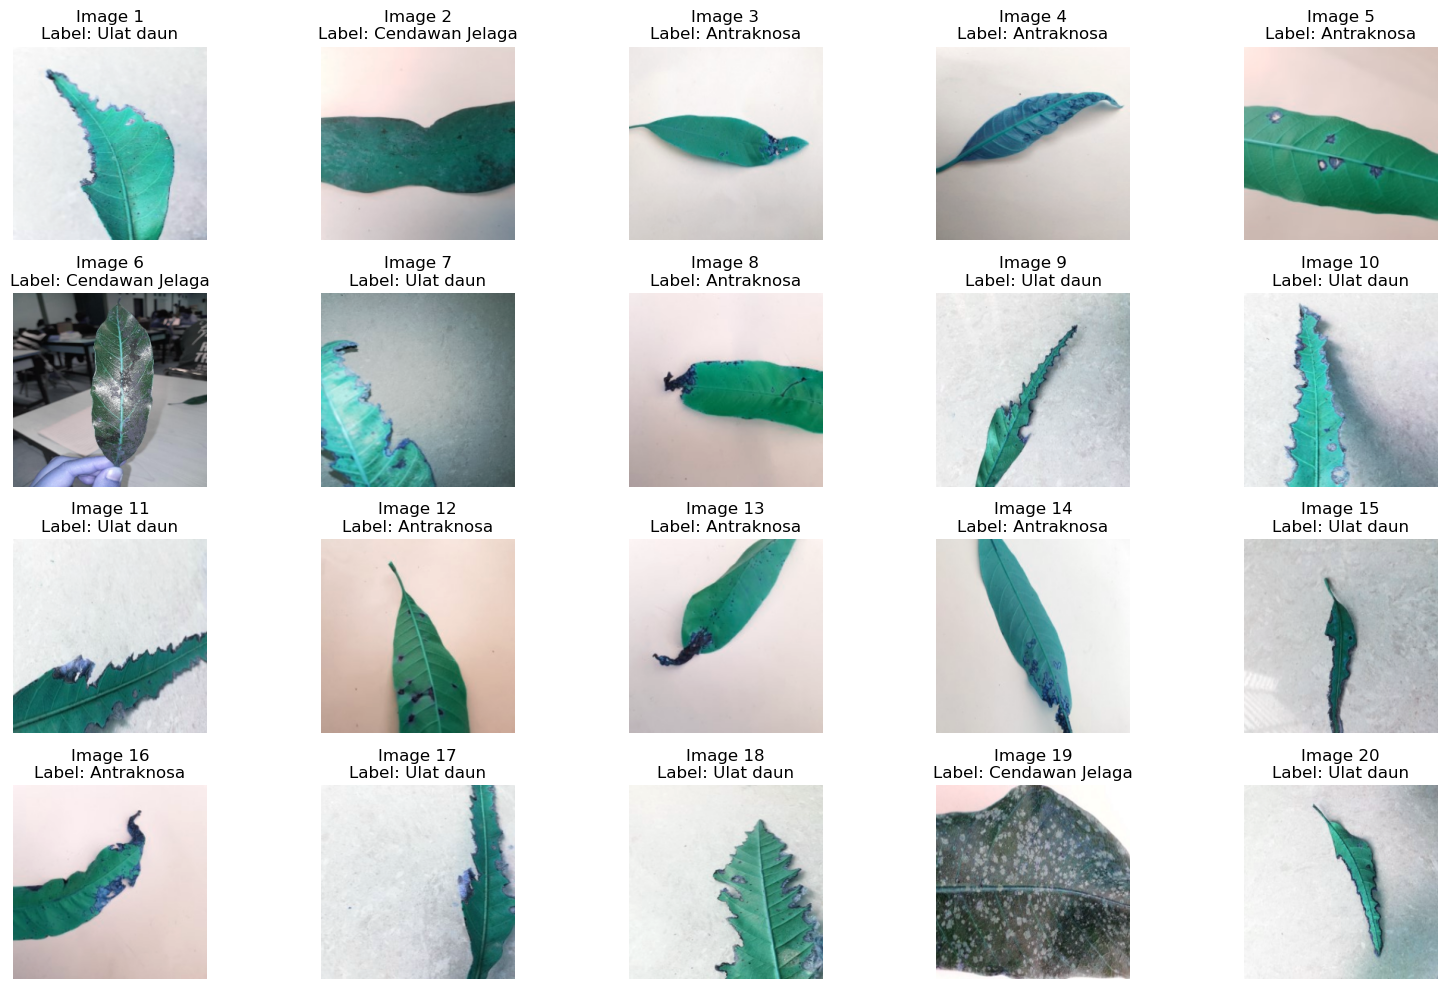

In [9]:
# Visualisasi 20 gambar sample dari training set
plt.figure(figsize=(16, 10))

# Ambil 20 indeks acak dari data latih
sample_indices = random.sample(range(len(x_train)), 20)

# Loop untuk menampilkan gambar
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_train[idx]))  # Menampilkan gambar
    label = np.argmax(y_train[idx])  # Menentukan label dengan one-hot encoding
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")  # Menampilkan judul dengan label
    plt.axis('off')  # Menyembunyikan axis

plt.tight_layout()
plt.show()

# b. Sample Test Images

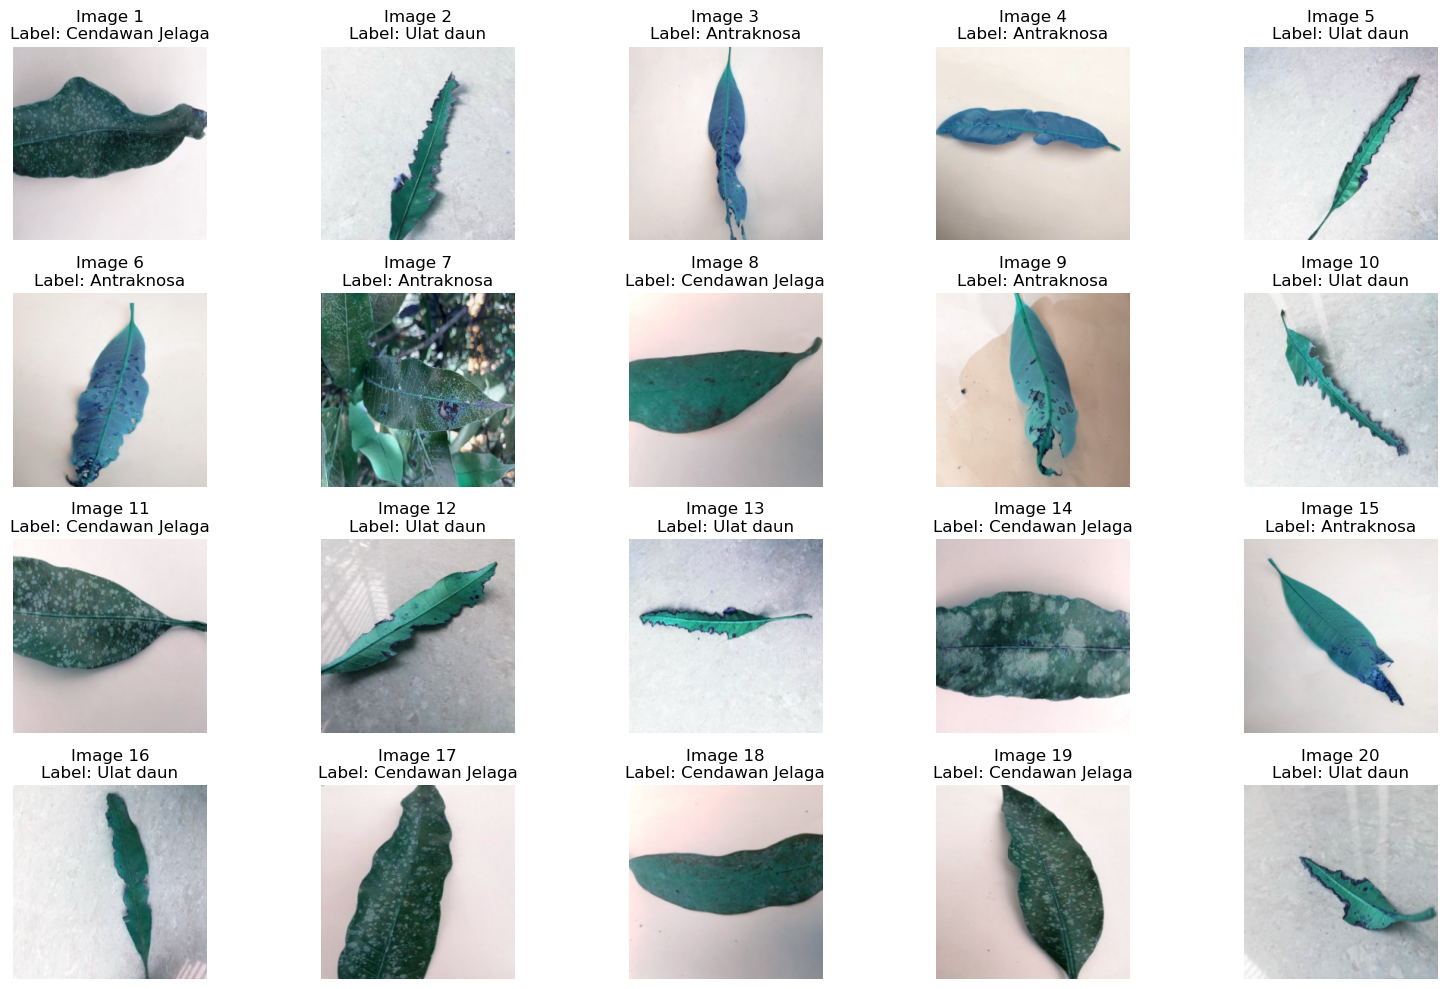

In [10]:
# Visualisasi 20 gambar sampel dari test set
plt.figure(figsize=(16, 10))

# Ambil 20 indeks acak dari data uji
sample_indices = random.sample(range(len(x_test)), 20)

# Loop untuk menampilkan gambar
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_test[idx]))  # Menampilkan gambar
    label = np.argmax(y_test[idx])  # Menentukan label dengan one-hot encoding
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")  # Menampilkan judul dengan label
    plt.axis('off')  # Menyembunyikan axis

plt.tight_layout()
plt.show()

# Model Definition

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Model ResNet50
def build_resnet50_model(input_shape=(256, 256, 3), num_classes=3):
    # Menggunakan ResNet50 tanpa top (fully connected layers)
    base_model = ResNet50(include_top=False, input_shape=input_shape)
    
    # Membuat model dengan layers tambahan setelah base model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Menggunakan global average pooling
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),  # Fully connected layer
        Dropout(0.6),  # Dropout untuk mencegah overfitting
        Dense(num_classes, activation='softmax')  # Output layer dengan softmax untuk multi-class classification
    ])
    
    return model

# Contoh penggunaan
resnet50_model = build_resnet50_model(input_shape=(256, 256, 3), num_classes=3)
resnet50_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 25,635,843 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Model Training

Training ResNet50 model...


c:\Users\Desrico\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - accuracy: 0.5238 - loss: 14.6751 - val_accuracy: 0.3392 - val_loss: 14.6443
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - accuracy: 0.9050 - loss: 13.7612 - val_accuracy: 0.3421 - val_loss: 14.6825
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.9488 - loss: 13.4439 - val_accuracy: 0.3596 - val_loss: 14.4530
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.9442 - loss: 13.2248 - val_accuracy: 0.3392 - val_loss: 14.2100
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.9673 - loss: 12.9725 - val_accuracy: 0.3509 - val_loss: 14.1116
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 364s 4s/step - accuracy: 0.9730 - loss: 12.7263 - val_accuracy: 0.4240 - val_loss: 13.6738
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.9766 - loss: 12.4918 - val_accuracy: 0.6053 - val_loss: 13.1871
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.9912 - loss: 12.2206 - val_accur

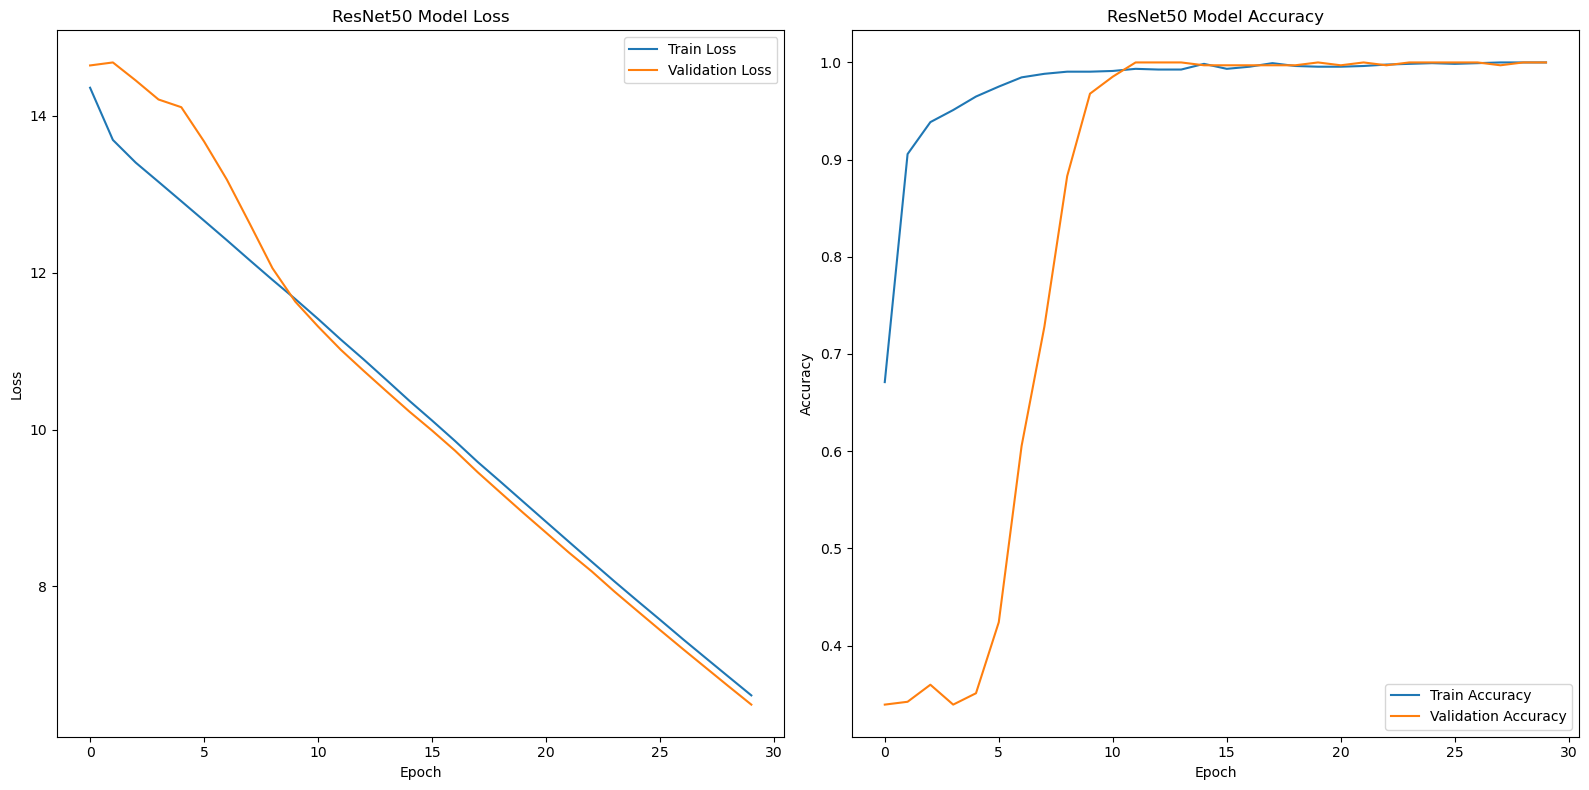

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Model ResNet50
def build_resnet50_model(input_shape=(256, 256, 3), num_classes=3):
    base_model = ResNet50(include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Definisi ImageDataGenerator untuk augmentasi data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training ResNet50
print("Training ResNet50 model...")
resnet50_model = build_resnet50_model(input_shape=(256, 256, 3), num_classes=3)
resnet50_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_resnet50 = resnet50_model.fit(
    datagen.flow(x_train, y_train, batch_size=16),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[early_stopping],
    verbose=1
)

# Save model and history
history_dict_resnet50 = history_resnet50.history

# Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# Loss
ax[0].plot(history_dict_resnet50['loss'], label='Train Loss')
ax[0].plot(history_dict_resnet50['val_loss'], label='Validation Loss')
ax[0].set_title('ResNet50 Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
# Accuracy
ax[1].plot(history_dict_resnet50['accuracy'], label='Train Accuracy')
ax[1].plot(history_dict_resnet50['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('ResNet50 Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


Evaluating ResNet50 model on test data...
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 6.4898
Test Loss: 6.4906
Test Accuracy: 1.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

Classification Report:
                 precision    recall  f1-score   support

     Antraknosa       1.00      1.00      1.00        32
Cendawan Jelaga       1.00      1.00      1.00        21
      Ulat daun       1.00      1.00      1.00        37

       accuracy                           1.00        90
      macro avg       1.00      1.00      1.00        90
   weighted avg       1.00      1.00      1.00        90



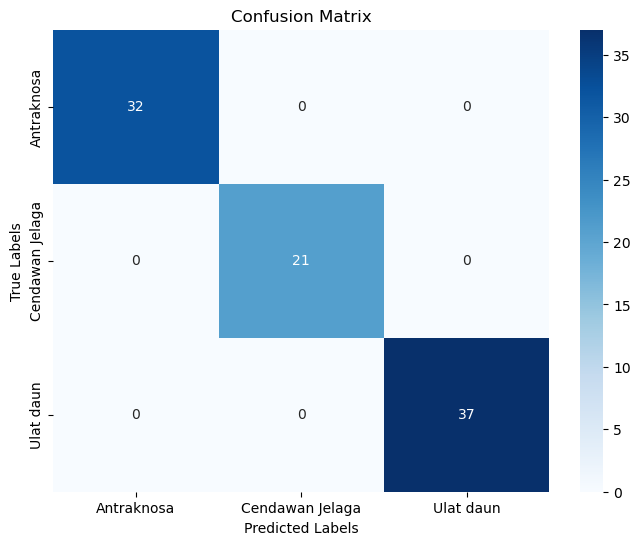

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluasi model menggunakan data test
print("Evaluating ResNet50 model on test data...")
test_loss, test_accuracy = resnet50_model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Prediksi data test
y_pred_probs = resnet50_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Ambil kelas dengan probabilitas tertinggi
y_true = np.argmax(y_test, axis=1)        # Ambil kelas sebenarnya dari one-hot encoding

# Laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Matriks kebingungan (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)

# Visualisasi matriks kebingungan
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import cv2
import numpy as np

def preprocess_for_display(image):
    """
    Pastikan gambar berada di RGB dan rentang nilai [0, 255].
    """
    # Jika gambar normalisasi dalam rentang [0, 1], ubah ke [0, 255]
    if np.max(image) <= 1.0:
        image = image * 255
    # Pastikan format uint8
    image = image.astype("uint8")
    # Konversi BGR ke RGB jika menggunakan OpenCV
    if image.shape[-1] == 3:  # Jika gambar memiliki 3 channel
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


In [17]:
# Daftar nama kelas
classes = ['Antraknosa', 'Cendawan Jelaga', 'Ulat Daun']  # Sesuaikan dengan model Anda

In [18]:
def output_plot(image, model, classes):
    """
    Menampilkan gambar input dan prediksi dari model.
    """
    # Preprocessing gambar untuk ditampilkan
    image_display = preprocess_for_display(image)
    
    plt.imshow(image_display)
    plt.axis('off')
    
    # Prediksi
    prediction = model.predict(np.expand_dims(image, axis=0))  # Tambahkan dimensi batch
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()




Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


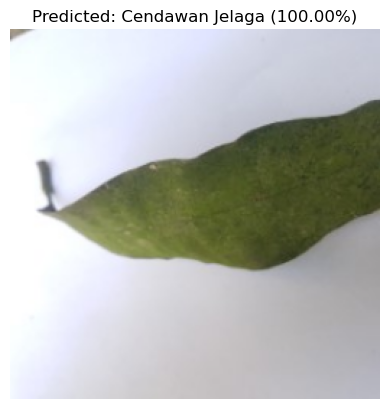



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


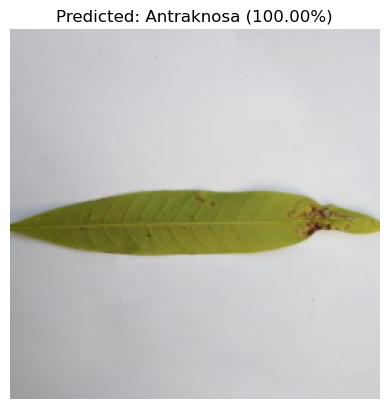



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


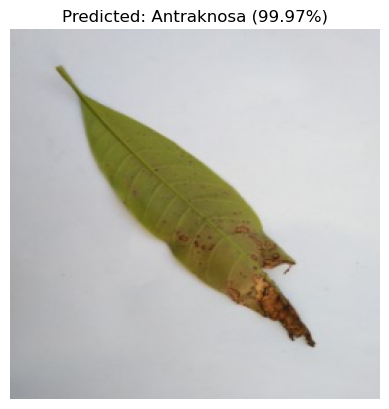



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


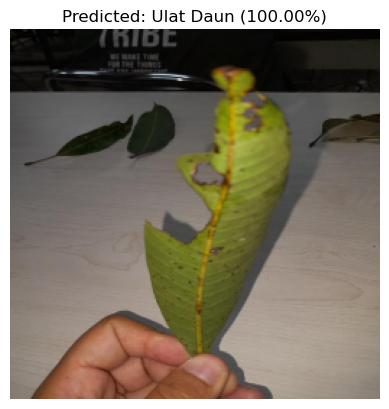



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


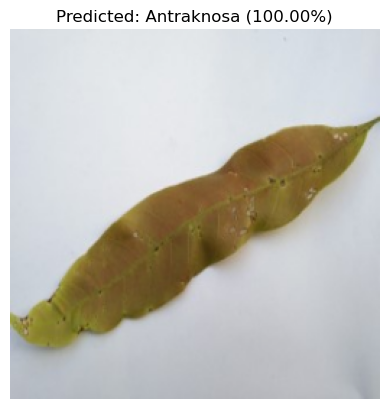



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


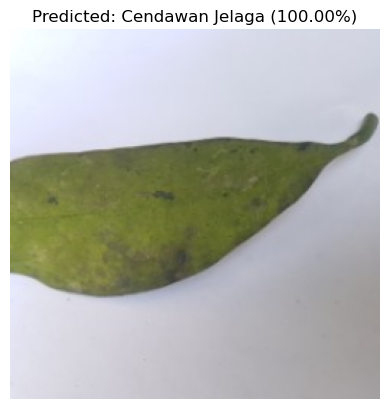



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


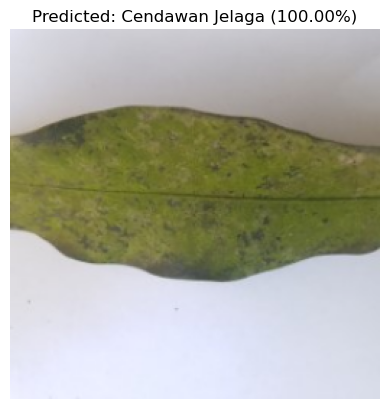



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


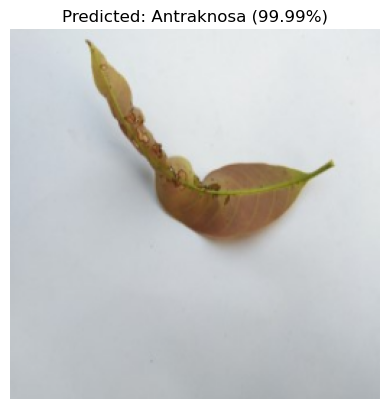



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


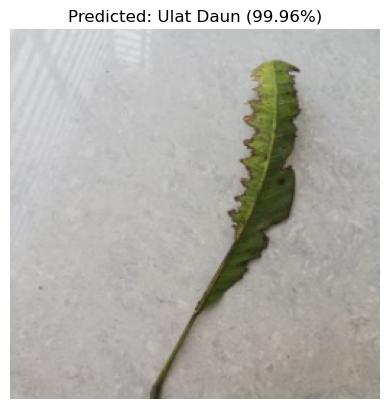



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


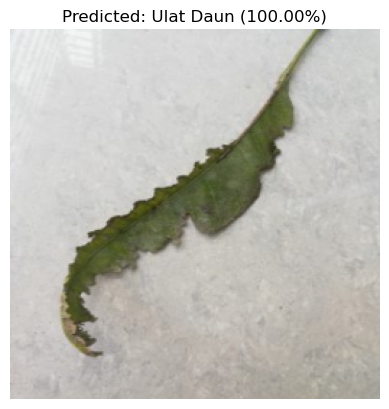



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


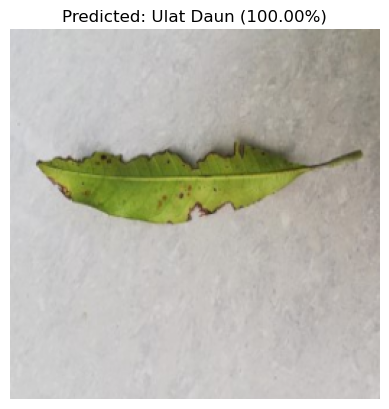



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


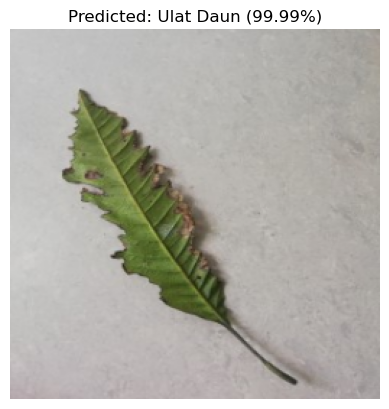



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


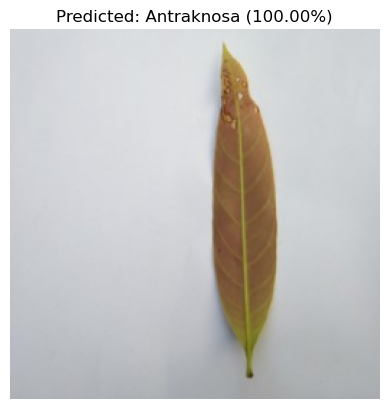



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


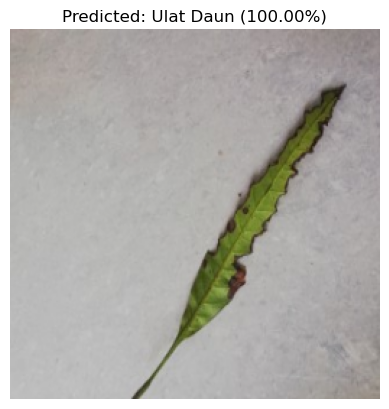



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


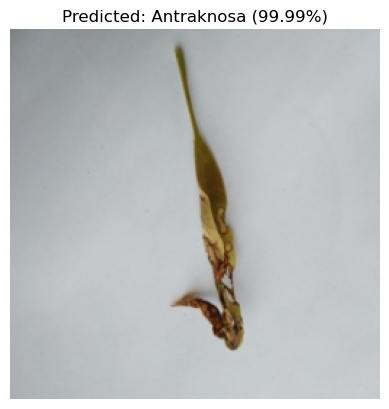

In [20]:
# Testing untuk beberapa gambar dari dataset uji
for i in range(20, 35):  # Pilih indeks gambar uji
    print(f"\n\nTesting - resnet50 Model\n")
    output_plot(x_test[i], resnet50_model, classes)

In [21]:
model = build_resnet50_model()  # Panggil fungsi untuk membangun model
model.save_weights('model_resnet50.weights.h5')  # Simpan bobot model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


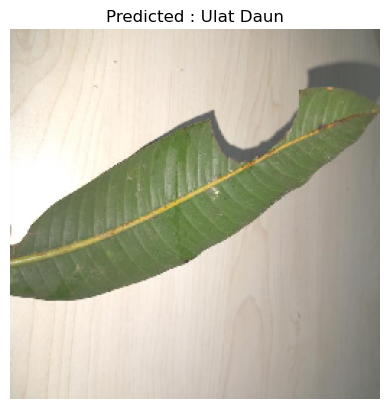

In [22]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Tetapkan label kelas secara manual
class_labels = ['Antraknosa', 'Cendawan Jelaga', 'Ulat Daun']  # Ganti dengan label yang sesuai

# Muat model dan bobot
model_path = 'D:/MATA KULIAH/SEMESTER 5/PM/Week 14/Praktikum/model_resnet50.weights.h5'
model = build_resnet50_model()  
model.load_weights(model_path)

def predict_and_display(image_path, model, class_labels):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted : {predicted_class_label}")
    plt.show()

# Path ke gambar uji
image_path_to_test = 'D:/MATA KULIAH/SEMESTER 5/PM/Week 14/Praktikum/Ulat daun/20241111_210658_jpg.rf.bb27959083bbc252b8612455d0b08a0b.jpg'

# Prediksi dan tampilkan hasil
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


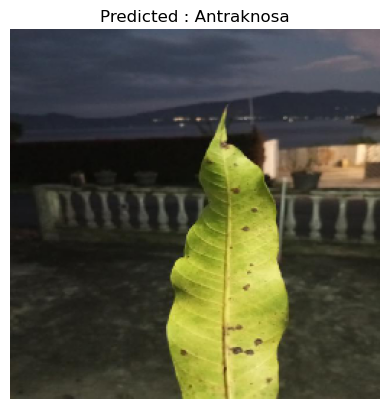

In [23]:
image_path_to_test = 'D:/MATA KULIAH/SEMESTER 5/PM/Week 14/Praktikum/antraknosa/16e49d55-a1d4-4d0c-ba6c-3d366ff98026_jpg.rf.46366b17a5ed4c570bb72bf13fd21e26.jpg'
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


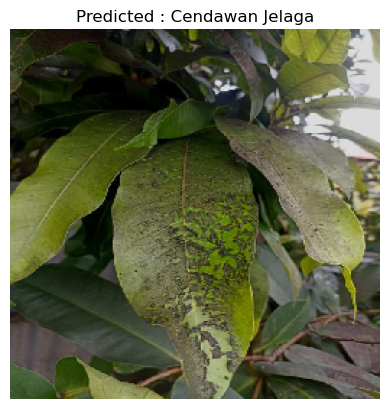

In [24]:
image_path_to_test = 'D:/MATA KULIAH/SEMESTER 5/PM/Week 14/Praktikum/Cendawan Jelaga/WhatsApp-Image-2024-10-29-at-09-42-10-1-_jpeg.rf.20e261df2dcc1c39d64340b67b31751a.jpg'
predict_and_display(image_path_to_test, model, class_labels)